In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle

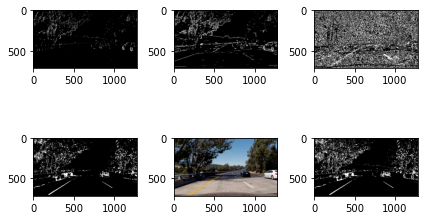

In [2]:
def abs_sobel_thresh(img, orient='x', thresh_min=20, thresh_max=100):
	"""
	Takes an image, gradient orientation, and threshold min/max values
	"""
	# Convert to grayscale
	gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
	# Apply x or y gradient with the OpenCV Sobel() function
	# and take the absolute value
	if orient == 'x':
		abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
	if orient == 'y':
		abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
	# Rescale back to 8 bit integer
	scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
	# Create a copy and apply the threshold
	binary_output = np.zeros_like(scaled_sobel)
	# Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
	binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

	# Return the result
	return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(30, 100)):
	"""
	Return the magnitude of the gradient
	for a given sobel kernel size and threshold values
	"""
	# Convert to grayscale
	gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
	# Take both Sobel x and y gradients
	sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
	sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
	# Calculate the gradient magnitude
	gradmag = np.sqrt(sobelx**2 + sobely**2)
	# Rescale to 8 bit
	scale_factor = np.max(gradmag)/255
	gradmag = (gradmag/scale_factor).astype(np.uint8)
	# Create a binary image of ones where threshold is met, zeros otherwise
	binary_output = np.zeros_like(gradmag)
	binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

	# Return the binary image
	return binary_output


def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
	"""
	Return the direction of the gradient
	for a given sobel kernel size and threshold values
	"""
	# Convert to grayscale
	gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
	# Calculate the x and y gradients
	sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
	sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
	# Take the absolute value of the gradient direction,
	# apply a threshold, and create a binary image result
	absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
	binary_output =  np.zeros_like(absgraddir)
	binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

	# Return the binary image
	return binary_output


def hls_thresh(img, thresh=(100, 255)):
	"""
	Convert RGB to HLS and threshold to binary image using S channel
	"""
	hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
	s_channel = hls[:,:,2]
	binary_output = np.zeros_like(s_channel)
	binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
	return binary_output


def combined_thresh(img):
	abs_bin = abs_sobel_thresh(img, orient='x', thresh_min=50, thresh_max=255)
	mag_bin = mag_thresh(img, sobel_kernel=3, mag_thresh=(50, 255))
	dir_bin = dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))
	hls_bin = hls_thresh(img, thresh=(170, 255))

	combined = np.zeros_like(dir_bin)
	combined[(abs_bin == 1 | ((mag_bin == 1) & (dir_bin == 1))) | hls_bin == 1] = 1

	return combined, abs_bin, mag_bin, dir_bin, hls_bin  # DEBUG


if __name__ == '__main__':
	img_file = 'test_images/straight_lines1.jpg'
	img_file = 'test_images/test5.jpg'

	with open('calibrate_camera.p', 'rb') as f:
		save_dict = pickle.load(f)
	mtx = save_dict['mtx']
	dist = save_dict['dist']

	img = mpimg.imread(img_file)
	img = cv2.undistort(img, mtx, dist, None, mtx)

	combined, abs_bin, mag_bin, dir_bin, hls_bin = combined_thresh(img)

	plt.subplot(2, 3, 1)
	plt.imshow(abs_bin, cmap='gray', vmin=0, vmax=1)
	plt.subplot(2, 3, 2)
	plt.imshow(mag_bin, cmap='gray', vmin=0, vmax=1)
	plt.subplot(2, 3, 3)
	plt.imshow(dir_bin, cmap='gray', vmin=0, vmax=1)
	plt.subplot(2, 3, 4)
	plt.imshow(hls_bin, cmap='gray', vmin=0, vmax=1)
	plt.subplot(2, 3, 5)
	plt.imshow(img)
	plt.subplot(2, 3, 6)
	plt.imshow(combined, cmap='gray', vmin=0, vmax=1)

	plt.tight_layout()
	plt.show()
